In [3269]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from matplotlib import rc
import missingno as msno #for missing values image
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm
from sklearn.decomposition import PCA
import mca # MCA
import scipy.cluster.hierarchy as shc
import math # for truncating floats
import cv2
import os, os.path
import PIL
from sklearn.model_selection import train_test_split

In [3270]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [3271]:
%watermark -a "Jason Wilcox" -d -t -v -p numpy,pandas

Jason Wilcox 2019-04-26 02:07:17 

CPython 3.6.5
IPython 6.4.0

numpy 1.14.3
pandas 0.23.0


In [3272]:
dota = pd.read_csv(r'C:\Users\jason\Desktop\dota2_survey.csv', sep=',') #5k rows

In [3273]:
dota.head(3)

,Timestamp,age,server,gender,years_dota2,games_week,badge,behaviour,solo_party,unranked_ranked,...,rate_this_week_learned,rate_stupid_questions,Unnamed: 42,show_case_badge,"Miscellaneous Feedback - Good things, bad things, anything!",follow_dota_esports,favorite_team,other_esports,follow_twitter,on_discord
0,1/13/2019 5:19:23,19-22,US East,Male,3 - 5 years,6 - 10,Legend,Normal,1.0,5.0,...,Like em,Like em,NaN,It shouldn't be done at all,pls fire vcrkid,I watch some events and the highlights for the...,Evil Geniuses,Starcraft,"I don't follow, becuase I don't use twitter or...",I'm in the server and participate regularly
1,1/13/2019 5:40:49,23-29,US West,Male,5 - 10 years,0 - 1 (play less than a game a week but still ...,Divine,A,2.0,2.0,...,Like em,Like em,NaN,It shouldn't be done at all,NaN,I only watch The International,Team Liquid,Counter Strike: Global Offensive,"I don't follow, because it's too spammy",I'm in the server and participate sometimes
2,1/13/2019 10:26:10,30-40,Europe East,Male,5 - 10 years,0 - 1 (play less than a game a week but still ...,Legend,Normal,2.0,3.0,...,Okay,Okay,NaN,It should only be allowed for Immortal players,NaN,I watch some events and the highlights for the...,Alliance,NaN,"I don't follow, becuase I don't use twitter or...",I'm in the server and participate regularly


## EDA

### Basic Info

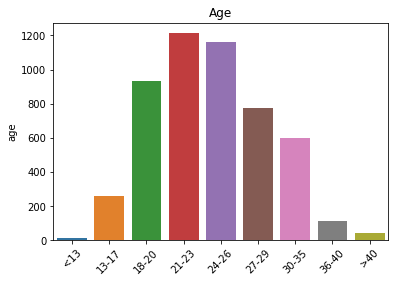

In [3274]:
ages = dota.age.value_counts()

sns.barplot(x= ages.index, y=ages, order=['<13', '13-17', '18-20', '21-23', '24-26', '27-29', '30-35', '36-40', '>40'])
plt.title('Age')
plt.xticks(rotation=45);

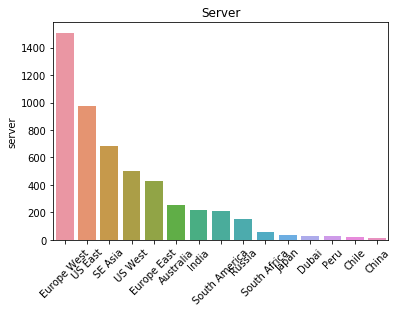

In [3275]:
server = dota.server.value_counts()

sns.barplot(x=server.index, y=server)
plt.title('Server')
plt.xticks(rotation=45);

## Explore some differences based on geographical regions

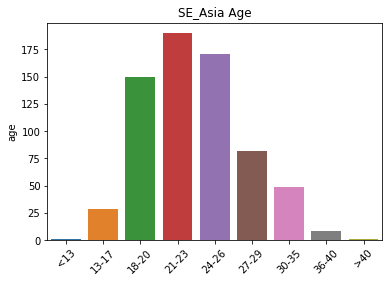

In [3276]:
SE_Asia = dota[dota['server'] == 'SE Asia']
test_age = SE_Asia.age.value_counts()
sns.barplot(x=test_age.index, y=test_age, order=['<13', '13-17', '18-20', '21-23', '24-26', '27-29', '30-35', '36-40', '>40'])
plt.title('SE_Asia Age')
plt.xticks(rotation=45);

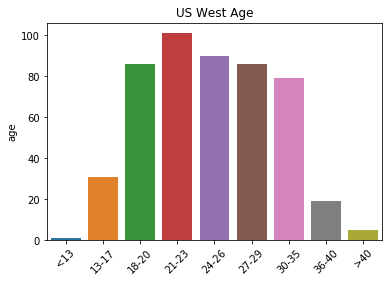

In [3277]:
SE_Asia = dota[dota['server'] == 'US West']
test_age = SE_Asia.age.value_counts()
sns.barplot(x=test_age.index, y=test_age, order=['<13', '13-17', '18-20', '21-23', '24-26', '27-29', '30-35', '36-40', '>40'])
plt.title('US West Age')
plt.xticks(rotation=45);

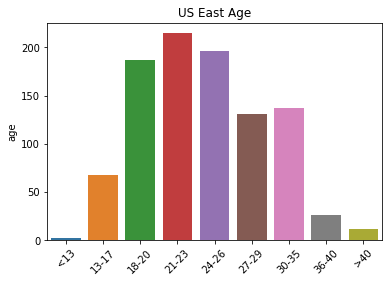

In [3278]:
SE_Asia = dota[dota['server'] == 'US East']
test_age = SE_Asia.age.value_counts()
sns.barplot(x=test_age.index, y=test_age, order=['<13', '13-17', '18-20', '21-23', '24-26', '27-29', '30-35', '36-40', '>40'])
plt.title('US East Age')
plt.xticks(rotation=45);

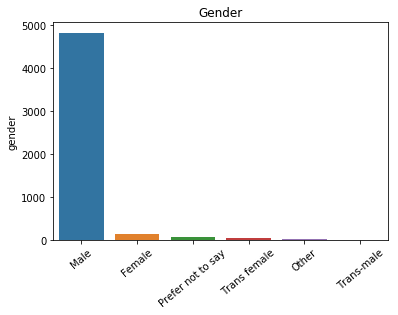

In [3279]:
gender = dota.gender.value_counts()

sns.barplot(x=gender.index, y=gender)
plt.title('Gender')
plt.xticks(rotation=40);

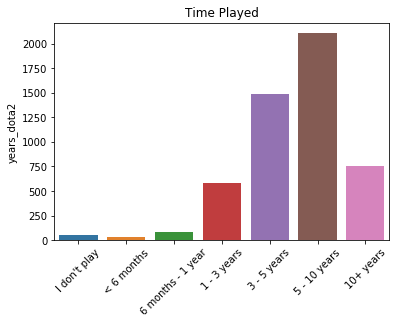

In [3280]:
years_dota2 = dota.years_dota2.value_counts()

sns.barplot(x=years_dota2.index, y=years_dota2, 
            order=['I don\'t play', '< 6 months', '6 months - 1 year', '1 - 3 years', '3 - 5 years', '5 - 10 years', '10+ years'])
plt.title('Time Played')
plt.xticks(rotation=45);

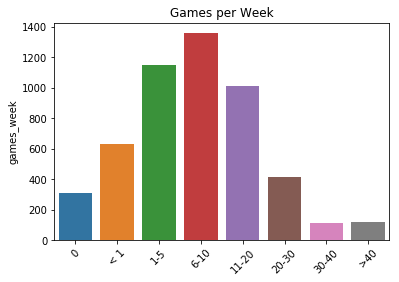

In [3281]:
games_week = dota.games_week.value_counts()

fig, ax=plt.subplots()
sns.barplot(x=games_week.index, y=games_week, order=['0', '0 - 1 (play less than a game a week but still play)', '1 - 5', '6 - 10', '11 - 20', '20 - 30', '30 - 40', '> 40'])
plt.title('Games per Week')
plt.xticks(np.arange(8), ['0', '< 1', '1-5', '6-10', '11-20', '20-30', '30-40', '>40'], rotation=45);

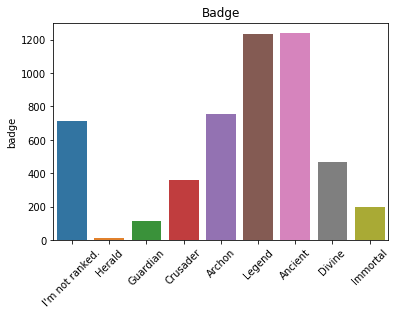

In [3282]:
badge = dota.badge.value_counts()

sns.barplot(x=badge.index, y=badge, order=['I\'m not ranked.', 'Herald', 'Guardian', 'Crusader', 'Archon', 'Legend', 'Ancient', 'Divine', 'Immortal'])
plt.title('Badge')
plt.xticks(rotation=45);

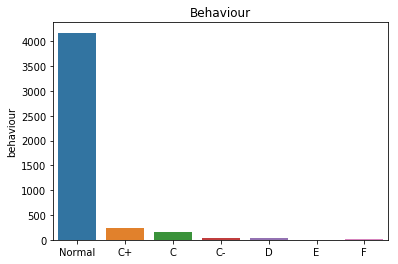

In [3283]:
behaviour=dota.behaviour.value_counts() # Ask cody for explanation
# fix 1 incorrect entry A -> Normal
dota.behaviour.replace(to_replace='A', value='Normal', inplace=True)

sns.barplot(x=behaviour.index, y=behaviour, order=['Normal', 'C+', 'C', 'C-', 'D', 'E', 'F'])
plt.title('Behaviour');

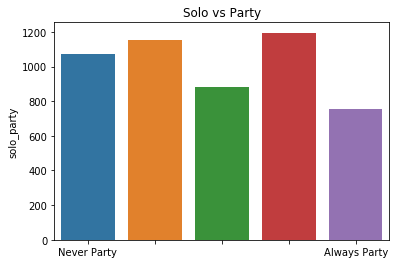

In [3284]:
solo = dota.solo_party.value_counts() # 1 always solo, 5 never solo

sns.barplot(x=solo.index, y=solo)
plt.xticks(np.arange(5), ['Never Party', '', '', '', 'Always Party'])
plt.title('Solo vs Party');

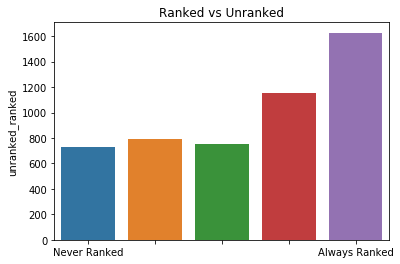

In [3285]:
ranked_play = dota.unranked_ranked.value_counts() # 1 never ranked, 5 always ranked

sns.barplot(x=ranked_play.index, y=ranked_play)
plt.xticks(np.arange(5), ['Never Ranked', '', '', '', 'Always Ranked'])
plt.title('Ranked vs Unranked');

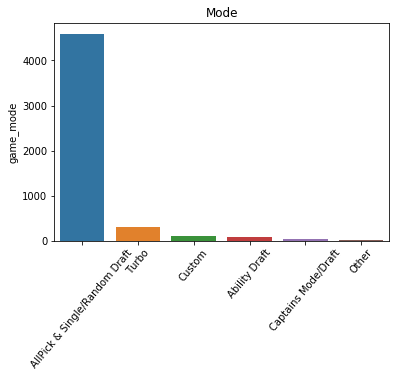

In [3286]:
game_mode = dota.game_mode.value_counts()

sns.barplot(x=game_mode.index, y=game_mode)
plt.title('Mode')
plt.xticks(np.arange(6), ['AllPick & Single/Random Draft', 'Turbo', 'Custom', 'Ability Draft', 'Captains Mode/Draft', 'Other'], rotation=50);

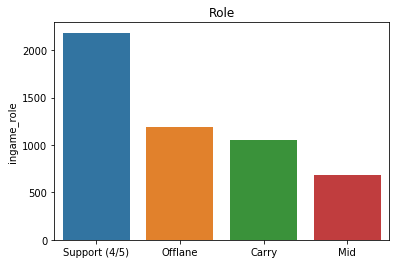

In [3287]:
role = dota.ingame_role.value_counts()

sns.barplot(x=role.index, y=role)
plt.title('Role');

### Forum Frequency

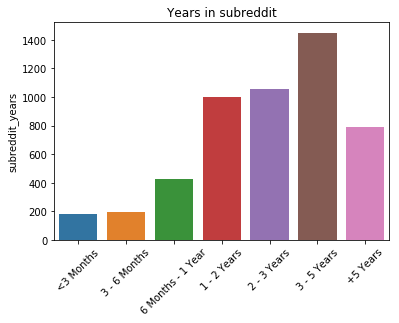

In [3288]:
reddit_years = dota.subreddit_years.value_counts()

sns.barplot(x=reddit_years.index, y=reddit_years, order=['<3 Months', '3 - 6 Months', '6 Months - 1 Year', '1 - 2 Years', '2 - 3 Years', '3 - 5 Years', '+5 Years'])
plt.title('Years in subreddit')
plt.xticks(rotation=45)
plt.show()

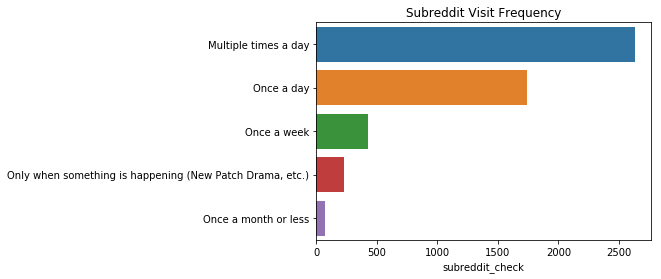

In [3289]:
visit_freq = dota.subreddit_check.value_counts()

sns.barplot(x=visit_freq, y=visit_freq.index)
plt.title('Subreddit Visit Frequency');

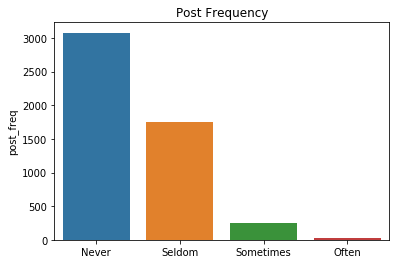

In [3290]:
post_freq = dota.post_freq.value_counts()

sns.barplot(x=post_freq.index, y=post_freq, order=['Never', 'Seldom', 'Sometimes', 'Often'])
plt.title('Post Frequency');

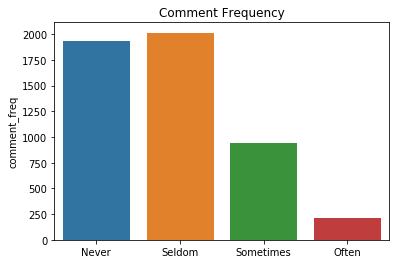

In [3291]:
comment_freq = dota.comment_freq.value_counts()

sns.barplot(x=comment_freq.index, y=comment_freq, order=['Never', 'Seldom', 'Sometimes', 'Often'])
plt.title('Comment Frequency');

### Importance Ratings

In [3292]:
# Fix disjointed values (either no number or missing text)
dota.loc[dota['patch_news_importance'].str.contains('3'), 'patch_news_importance'] = '3 = Sort of Important'
dota.loc[dota['patch_news_importance'].str.contains('2'), 'patch_news_importance'] = '2 = Sort of Not Important'

dota.loc[2, 'patch_news_importance'] = '4 = Very Important'
dota.loc[0, 'patch_news_importance'] = '4 = Very Important'
dota.loc[1, 'patch_news_importance'] = '3 = Sort of Important'

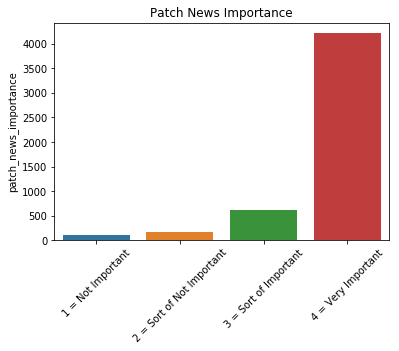

In [3293]:
news = dota.patch_news_importance.value_counts()

sns.barplot(x=news.index, y=news, order=['1 = Not Important', '2 = Sort of Not Important', '3 = Sort of Important', '4 = Very Important'])
plt.title('Patch News Importance')
plt.xticks(rotation=45);

In [3294]:
# Fix mixed data missing number/text
# dota[dota['bug_reports_importance'] == 'Sort of important']

dota.loc[dota['bug_reports_importance'].str.contains('3'), 'bug_reports_importance'] = '3 = Sort of Important'
dota.loc[dota['bug_reports_importance'].str.contains('2'), 'bug_reports_importance'] = '2 = Sort of Not Important'

dota.loc[2, 'bug_reports_importance'] = '2 = Sort of Not Important'
dota.loc[0, 'bug_reports_importance'] = '2 = Sort of Not Important'
dota.loc[1, 'bug_reports_importance'] = '3 = Sort of Important'

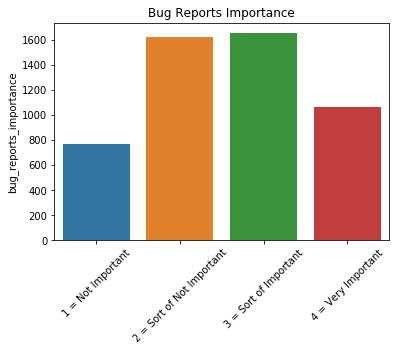

In [3295]:
bugs = dota.bug_reports_importance.value_counts() 

sns.barplot(x=bugs.index, y=bugs, order=['1 = Not Important', '2 = Sort of Not Important', '3 = Sort of Important', '4 = Very Important'])
plt.title('Bug Reports Importance')
plt.xticks(rotation=45);

In [3296]:
dota.loc[dota['user_created_content_imp'].str.contains('3'), 'user_created_content_imp'] = '3 = Sort of Important'
dota.loc[dota['user_created_content_imp'].str.contains('2'), 'user_created_content_imp'] = '2 = Sort of Not Important'

dota.loc[2, 'user_created_content_imp'] = '3 = Sort of Important'
dota.loc[0, 'user_created_content_imp'] = '3 = Sort of Important'
dota.loc[1, 'user_created_content_imp'] = '3 = Sort of Important'

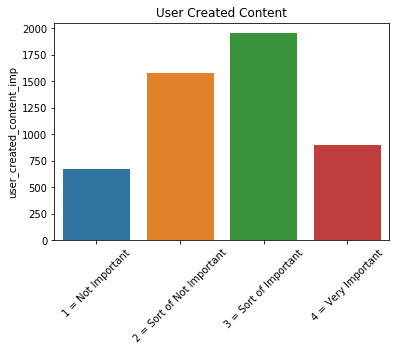

In [3297]:
user_content = dota.user_created_content_imp.value_counts() 

sns.barplot(x=user_content.index, y=user_content, order=['1 = Not Important', '2 = Sort of Not Important', '3 = Sort of Important', '4 = Very Important'])
plt.title('User Created Content')
plt.xticks(rotation=45);

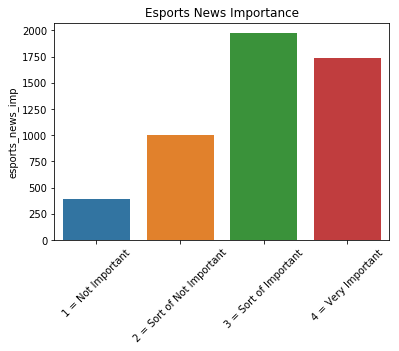

In [3298]:
# fix spelling error in column name
dota.rename(columns={'eports_news_imp':'esports_news_imp'}, inplace=True)

# Fix inconsistent values
dota.loc[dota['esports_news_imp'].str.contains('3'), 'esports_news_imp'] = '3 = Sort of Important'
dota.loc[dota['esports_news_imp'].str.contains('2'), 'esports_news_imp'] = '2 = Sort of Not Important'
dota.loc[dota['esports_news_imp'].str.contains('Sort of important'), 'esports_news_imp'] = '3 = Sort of Important'



esports_news = dota.esports_news_imp.value_counts() 

sns.barplot(x=esports_news.index, y=esports_news, order=['1 = Not Important', '2 = Sort of Not Important', '3 = Sort of Important', '4 = Very Important'])
plt.title('Esports News Importance')
plt.xticks(rotation=45);

In [3299]:
# fix spelling in column name
dota.rename(columns={'gamplay_discuss_imp':'gameplay_discussion_imp'}, inplace=True)

# fix inconsistent values
dota.loc[dota['gameplay_discussion_imp'].str.contains('3'), 'gameplay_discussion_imp'] = '3 = Sort of Important'
dota.loc[dota['gameplay_discussion_imp'].str.contains('2'), 'gameplay_discussion_imp'] = '2 = Sort of Not Important'
dota.loc[dota['gameplay_discussion_imp'].str.contains('Sort of important'), 'gameplay_discussion_imp'] = '3 = Sort of Important'

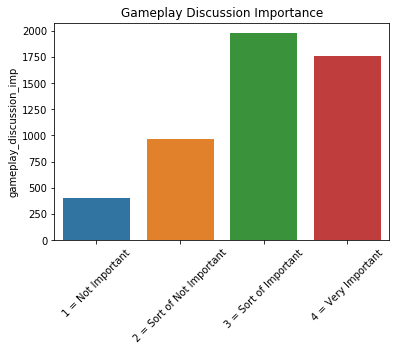

In [3300]:
gameplay_discussion_imp = dota.gameplay_discussion_imp.value_counts()


sns.barplot(x=gameplay_discussion_imp.index, y=gameplay_discussion_imp, order=['1 = Not Important', '2 = Sort of Not Important',
                                                                               '3 = Sort of Important', '4 = Very Important'])
plt.title('Gameplay Discussion Importance')
plt.xticks(rotation=45)
plt.show();

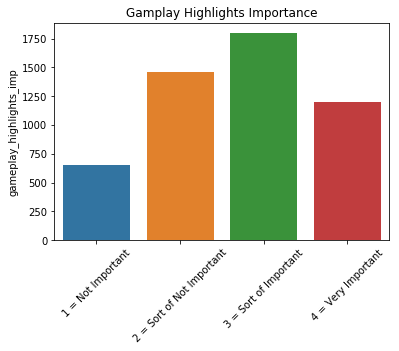

In [3301]:
# fix label spelling error
dota.rename(columns={'gamplay_highlights_imp':'gameplay_highlights_imp'}, inplace=True)

# fix inconsistent values
dota.loc[dota['gameplay_highlights_imp'].str.contains('3'), 'gameplay_highlights_imp'] = '3 = Sort of Important'
dota.loc[dota['gameplay_highlights_imp'].str.contains('2'), 'gameplay_highlights_imp'] = '2 = Sort of Not Important'
dota.loc[dota['gameplay_highlights_imp'].str.contains('Sort of important'), 'gameplay_highlights_imp'] = '3 = Sort of Important'

gameplay_highlights_imp = dota.gameplay_highlights_imp.value_counts()

sns.barplot(x=gameplay_highlights_imp.index, y=gameplay_highlights_imp, order=['1 = Not Important', '2 = Sort of Not Important',
                                                                               '3 = Sort of Important', '4 = Very Important'])
plt.title('Gamplay Highlights Importance')
plt.xticks(rotation=45)
plt.show();

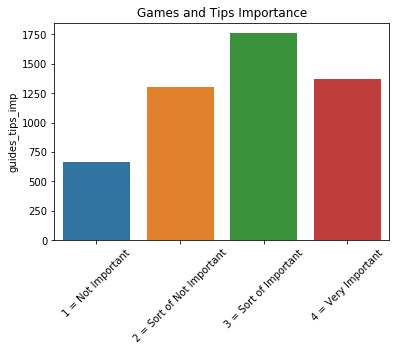

In [3302]:
# fix inconsistent values
dota.loc[dota['guides_tips_imp'].str.contains('3'), 'guides_tips_imp'] = '3 = Sort of Important'
dota.loc[dota['guides_tips_imp'].str.contains('2'), 'guides_tips_imp'] = '2 = Sort of Not Important'
dota.loc[dota['guides_tips_imp'].str.contains('Sort of important'), 'guides_tips_imp'] = '3 = Sort of Important'

guides_tips_imp = dota.guides_tips_imp.value_counts()

sns.barplot(x=guides_tips_imp.index, y=guides_tips_imp, order=['1 = Not Important', '2 = Sort of Not Important',
                                                                               '3 = Sort of Important', '4 = Very Important'])
plt.title('Games and Tips Importance')
plt.xticks(rotation=45)
plt.show();

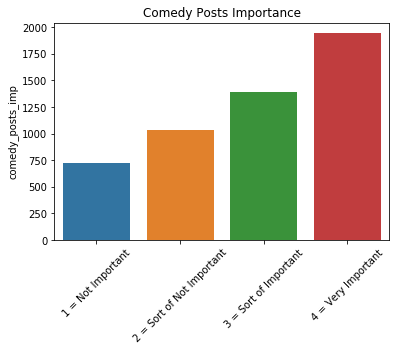

In [3303]:
# fix inconsistent values
dota.loc[dota['comedy_posts_imp'].str.contains('3'), 'comedy_posts_imp'] = '3 = Sort of Important'
dota.loc[dota['comedy_posts_imp'].str.contains('2'), 'comedy_posts_imp'] = '2 = Sort of Not Important'
dota.loc[dota['comedy_posts_imp'].str.contains('Sort of important'), 'comedy_posts_imp'] = '3 = Sort of Important'
dota.loc[dota['comedy_posts_imp'].str.contains('Very important'), 'comedy_posts_imp'] = '4 = Very Important'


comedy_posts_imp = dota.comedy_posts_imp.value_counts()

sns.barplot(x=comedy_posts_imp.index, y=comedy_posts_imp, order=['1 = Not Important', '2 = Sort of Not Important',
                                                                               '3 = Sort of Important', '4 = Very Important'])
plt.title('Comedy Posts Importance')
plt.xticks(rotation=45)
plt.show();

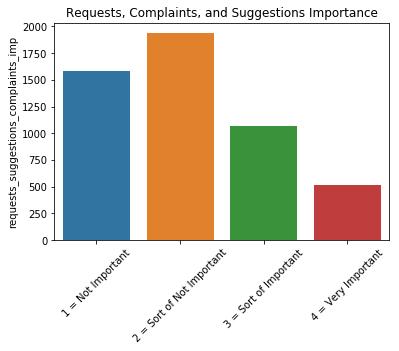

In [3304]:
# fix inconsistent values
dota.loc[dota['requests_suggestions_complaints_imp'].str.contains('3'), 'requests_suggestions_complaints_imp'] = '3 = Sort of Important'
dota.loc[dota['requests_suggestions_complaints_imp'].str.contains('2'), 'requests_suggestions_complaints_imp'] = '2 = Sort of Not Important'
dota.loc[dota['requests_suggestions_complaints_imp'].str.contains('Sort of important'), 'requests_suggestions_complaints_imp'] = '3 = Sort of Important'
dota.loc[dota['requests_suggestions_complaints_imp'].str.contains('Sort of not important'), 'requests_suggestions_complaints_imp'] = '2 = Sort of Not Important'


requests_complaints_imp = dota.requests_suggestions_complaints_imp.value_counts()

sns.barplot(x=requests_complaints_imp.index, y=requests_complaints_imp, order=['1 = Not Important', '2 = Sort of Not Important',
                                                                               '3 = Sort of Important', '4 = Very Important'])
plt.title('Requests, Complaints, and Suggestions Importance')
plt.xticks(rotation=45)
plt.show();

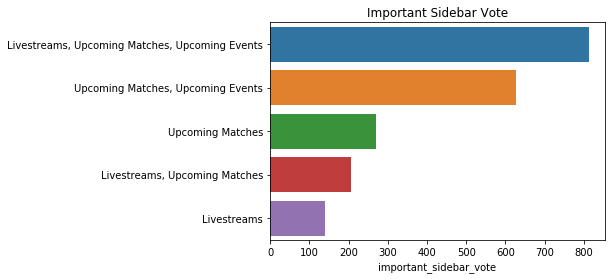

In [3305]:
#fix label spelling
dota.rename(columns={'important_sidbar_vote':'important_sidebar_vote'}, inplace=True)

important_sidebar_vote = dota.important_sidebar_vote.value_counts().head()

sns.barplot(x=important_sidebar_vote, y=important_sidebar_vote.index)
plt.title('Important Sidebar Vote')
plt.show()

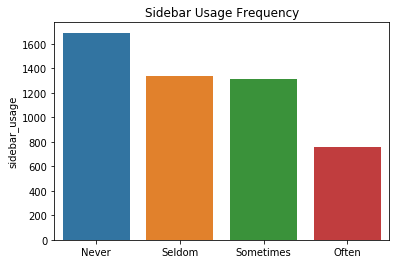

In [3306]:
sidebar_usage = dota.sidebar_usage.value_counts()

sns.barplot(x=sidebar_usage.index, y=sidebar_usage)
plt.title('Sidebar Usage Frequency')
plt.show()

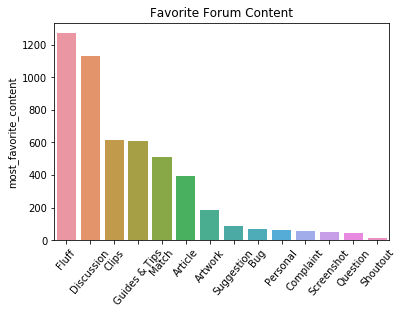

In [3307]:
favorite_content = dota.most_favorite_content.value_counts()

sns.barplot(x=favorite_content.index, y=favorite_content)
plt.title('Favorite Forum Content')
plt.xticks(rotation=50);

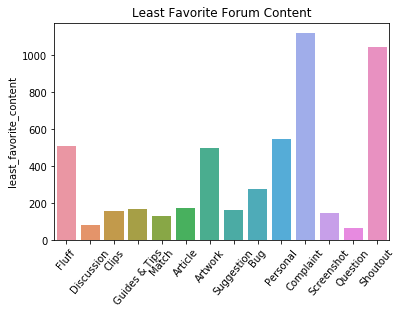

In [3308]:
least_fav_content = dota.least_favorite_content.value_counts()

sns.barplot(x=least_fav_content.index, y=least_fav_content, order=['Fluff', 'Discussion', 'Clips', 'Guides & Tips', 'Match', 'Article', 'Artwork', 'Suggestion', 'Bug', 'Personal', 'Complaint', 'Screenshot', 'Question', 'Shoutout'])
plt.title('Least Favorite Forum Content')
plt.xticks(rotation=50);

### 4 Point Ratings

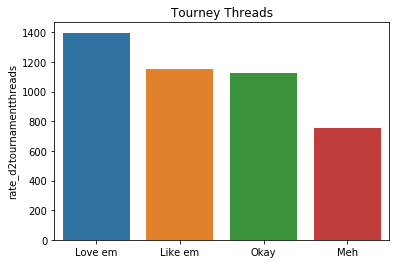

In [3309]:
rate_tourney = dota.rate_d2tournamentthreads.value_counts() 

sns.barplot(x=rate_tourney.index, y=rate_tourney, order=['Love em', 'Like em', 'Okay', 'Meh'])
plt.title('Tourney Threads');

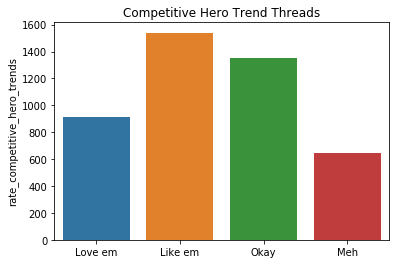

In [3310]:
rate_hero_trends = dota.rate_competitive_hero_trends.value_counts() 

sns.barplot(x=rate_hero_trends.index, y=rate_hero_trends, order=['Love em', 'Like em', 'Okay', 'Meh'])
plt.title('Competitive Hero Trend Threads'); 

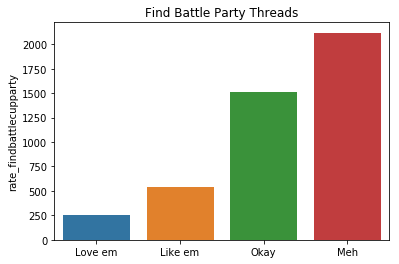

In [3311]:
rate_find_party = dota.rate_findbattlecupparty.value_counts() 

sns.barplot(x=rate_find_party.index, y=rate_find_party, order=['Love em', 'Like em', 'Okay', 'Meh'])
plt.title('Find Battle Party Threads');

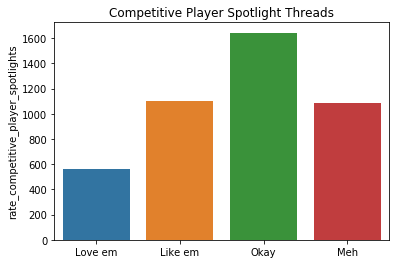

In [3312]:
rate_player_spotlights = dota.rate_competitive_player_spotlights.value_counts() 

sns.barplot(x=rate_player_spotlights.index, y=rate_player_spotlights, order=['Love em', 'Like em', 'Okay', 'Meh'])
plt.title('Competitive Player Spotlight Threads');

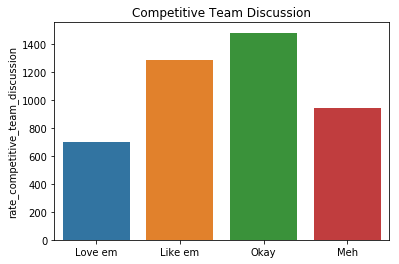

In [3313]:
rate_teams = dota.rate_competitive_team_discussion.value_counts() 

sns.barplot(x=rate_teams.index, y=rate_teams, order=['Love em', 'Like em', 'Okay', 'Meh'])
plt.title('Competitive Team Discussion');

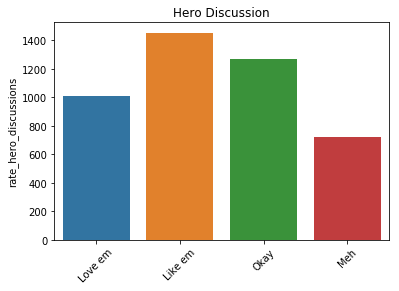

In [3314]:
rate_hero_disc = dota.rate_hero_discussions.value_counts() 

sns.barplot(x=rate_hero_disc.index, y=rate_hero_disc, order=['Love em', 'Like em', 'Okay', 'Meh'])
plt.title('Hero Discussion')
plt.xticks(rotation=45);

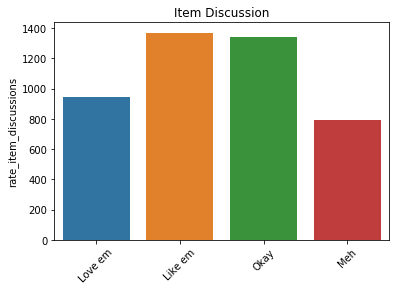

In [3315]:
rate_item_disc = dota.rate_item_discussions.value_counts() 

sns.barplot(x=rate_item_disc.index, y=rate_item_disc, order=['Love em', 'Like em', 'Okay', 'Meh'])
plt.title('Item Discussion')
plt.xticks(rotation=45);

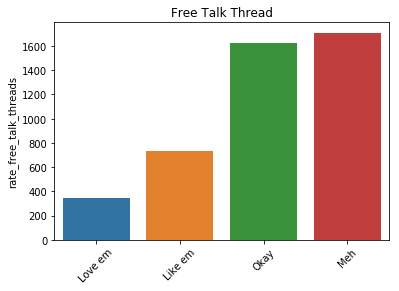

In [3316]:
rate_free_talk_thread = dota.rate_free_talk_threads.value_counts() 

sns.barplot(x=rate_free_talk_thread.index, y=rate_free_talk_thread, order=['Love em', 'Like em', 'Okay', 'Meh'])
plt.title('Free Talk Thread')
plt.xticks(rotation=45);

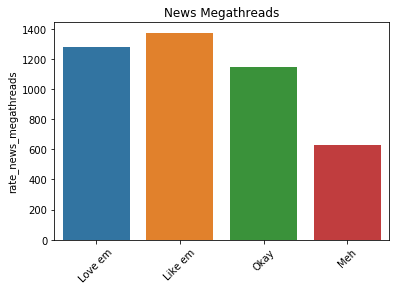

In [3317]:
rate_news_megathreads = dota.rate_news_megathreads.value_counts() 

sns.barplot(x=rate_news_megathreads.index, y=rate_news_megathreads, order=['Love em', 'Like em', 'Okay', 'Meh'])
plt.title('News Megathreads')
plt.xticks(rotation=45);

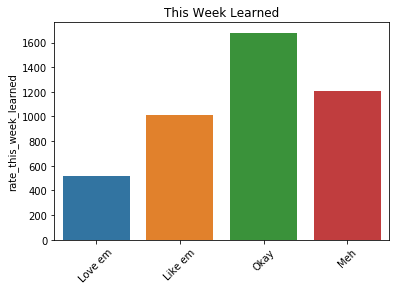

In [3318]:
rate_this_week_learned = dota.rate_this_week_learned.value_counts() 

sns.barplot(x=rate_this_week_learned.index, y=rate_this_week_learned, order=['Love em', 'Like em', 'Okay', 'Meh'])
plt.title('This Week Learned')
plt.xticks(rotation=45);

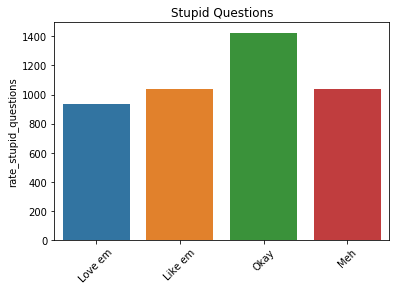

In [3319]:
rate_stupid_questions = dota.rate_stupid_questions.value_counts() 

sns.barplot(x=rate_stupid_questions.index, y=rate_stupid_questions, order=['Love em', 'Like em', 'Okay', 'Meh'])
plt.title('Stupid Questions')
plt.xticks(rotation=45);

## Misc

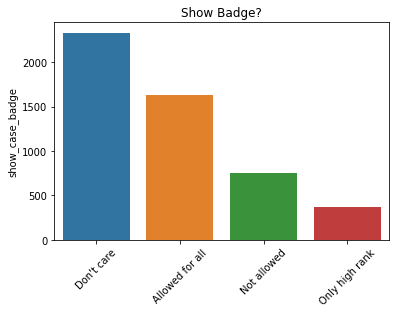

In [3320]:
show_badge = dota.show_case_badge.value_counts().head(4) # limit responses in open question

sns.barplot(x=show_badge.index, y=show_badge)
plt.title('Show Badge?')
plt.xticks(np.arange(4), ['Don\'t care', 'Allowed for all', 'Not allowed', 'Only high rank'], rotation=45);

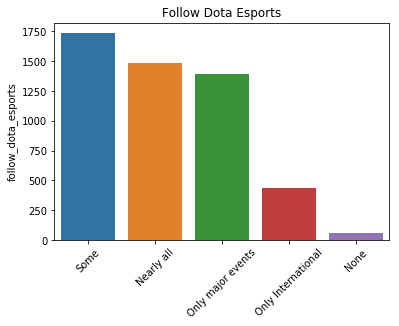

In [3321]:
follow_dota_esports = dota.follow_dota_esports.value_counts() 

sns.barplot(x=follow_dota_esports.index, y=follow_dota_esports)
plt.title('Follow Dota Esports')
plt.xticks(np.arange(5), ['Some', 'Nearly all', 'Only major events', 'Only International', 'None'], rotation=45);

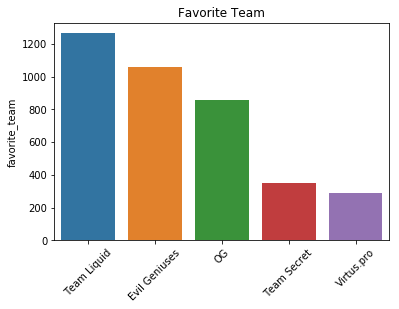

In [3322]:
fav_team = dota.favorite_team.value_counts().head()  # take top responses with open question

sns.barplot(x=fav_team.index, y=fav_team)
plt.title('Favorite Team')
plt.xticks(rotation=45);

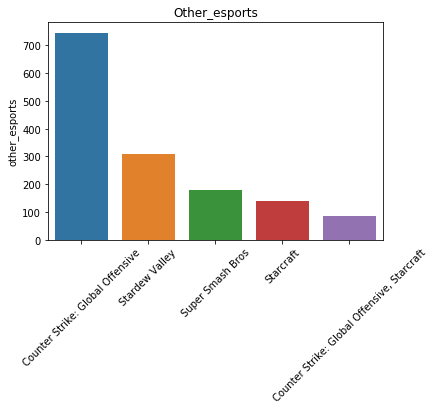

In [3323]:
other_esports = dota.other_esports.value_counts().head() 

sns.barplot(x=other_esports.index, y=other_esports)
plt.title('Other_esports')
plt.xticks(rotation=45);

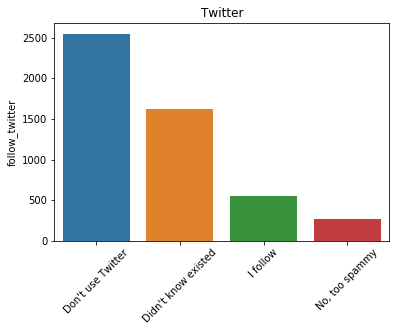

In [3324]:
twitter = dota.follow_twitter.value_counts().head(4)

sns.barplot(x=twitter.index, y=twitter)
plt.title('Twitter')
plt.xticks(np.arange(4), ['Don\'t use Twitter', 'Didn\'t know existed', 'I follow', 'No, too spammy'], rotation=45);

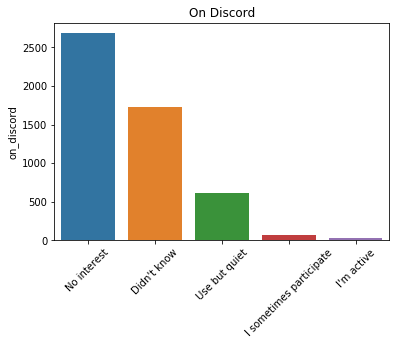

In [3325]:
discord = dota.on_discord.value_counts() 

sns.barplot(x=discord.index, y=discord)
plt.title('On Discord')
plt.xticks(np.arange(5), ['No interest', 'Didn\'t know', 'Use but quiet', 'I sometimes participate', 'I\'m active'], rotation=45);

### Stacked Plot

#### 4 Point Questions:

In [3326]:
# Create new dfs for just the ratings and importance scale questions
ratings_df = dota[['rate_d2tournamentthreads', 'rate_competitive_hero_trends', 'rate_findbattlecupparty', 
                  'rate_competitive_player_spotlights', 'rate_competitive_team_discussion', 'rate_hero_discussions',
                  'rate_item_discussions', 'rate_free_talk_threads', 'rate_news_megathreads', 'rate_this_week_learned',
                  'rate_stupid_questions']]

importance_df = dota[['patch_news_importance', 'bug_reports_importance', 'user_created_content_imp', 'esports_news_imp',
                             'gameplay_discussion_imp', 'gameplay_highlights_imp', 'guides_tips_imp', 'requests_suggestions_complaints_imp']]


In [3327]:
# Clean up column names for later use
ratings_names = {'rate_d2tournamentthreads':'D2 Tournament', 
                 'rate_competitive_hero_trends':'Comp Hero Trends', 
                 'rate_findbattlecupparty':'Find Battle Cup Party', 
                 'rate_competitive_player_spotlights':'Comp Player Spotlight', 
                 'rate_competitive_team_discussion':'Comp Team Discussion', 
                 'rate_hero_discussions':'Hero Discussion', 
                 'rate_item_discussions':'Item Discussion', 
                 'rate_free_talk_threads':'Free Talk', 
                 'rate_news_megathreads':'News', 
                 'rate_this_week_learned':'This Week Learned', 
                 'rate_stupid_questions':'Stupid Questions'}

ratings_df.rename(columns=ratings_names, inplace=True)

importance_names = {'patch_news_importance':'Patch News',
                    'bug_reports_importance':'Bug Reports',
                    'user_created_content_imp':'User Created Content',
                    'esports_news_imp':'Esports News',
                    'gameplay_discussion_imp':'Gameplay Discussion',
                    'gameplay_highlights_imp':'Gameplay Highlights',
                    'guides_tips_imp':'Guids and Tips',
                    'requests_suggestions_complaints_imp':'Requests, Suggestions, Complaints, etc'}

importance_df.rename(columns=importance_names, inplace=True)

C:\Users\jason\Anaconda3\lib\site-packages\pandas\core\frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [3328]:
# Create a function to make a new df of % responses
def percent_count_df(dataframe):
    '''Takes a dataframe and converts the results into percents based on counts and returns a new dataframe'''
    # initialize counts
    counts=[]

    for column in dataframe:
    # convert to %
        counts.append((dataframe[column].value_counts()/sum(dataframe[column].value_counts())))
    # create new df with values
        counts_df = pd.DataFrame(counts)
    
    return counts_df    

In [3329]:
# Make new df's with % responses per question and sort columns from bad to good*
percent_ratings = percent_count_df(ratings_df)
percent_ratings = percent_ratings[['Meh', 'Okay', 'Like em', 'Love em']]

percent_importance = percent_count_df(importance_df)
percent_importance = percent_importance[['1 = Not Important', '2 = Sort of Not Important', '3 = Sort of Important', '4 = Very Important']]

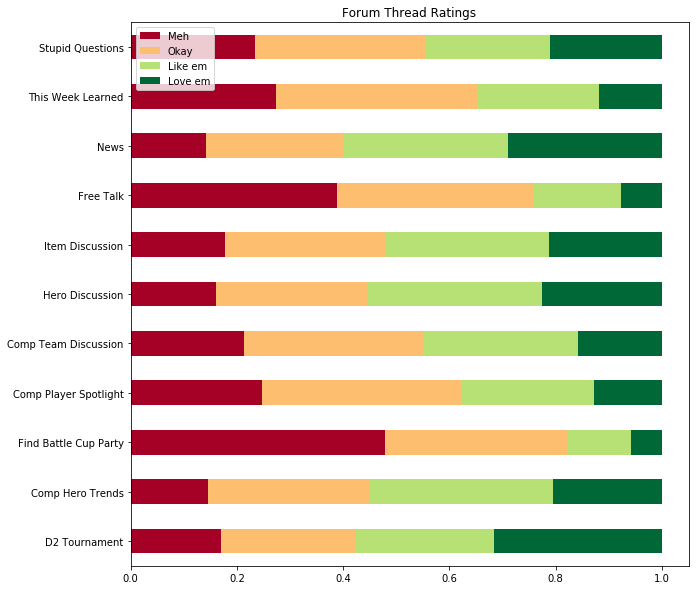

In [3330]:
# Create graphs of the responses
ax = percent_ratings.plot(kind='barh', stacked=True, title='Forum Thread Ratings', colormap='RdYlGn', 
                          legend=False, figsize=(10,10))

patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, labels, loc='upper left', fontsize=10);

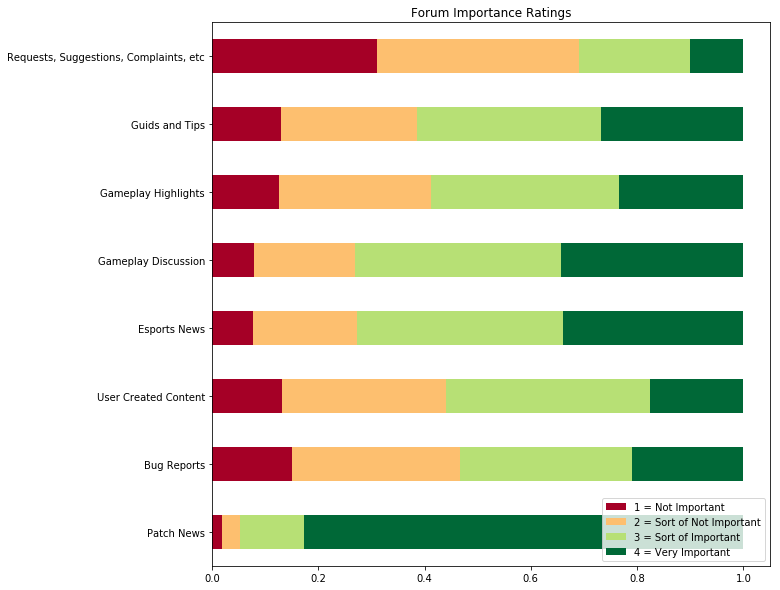

In [3331]:
ax2 = percent_importance.plot(kind='barh', stacked=True, title='Forum Importance Ratings', colormap='RdYlGn', 
                          legend=False, figsize=(10,10))

patches, labels = ax2.get_legend_handles_labels()
ax2.legend(patches, labels, loc='lower right', fontsize=10);

## Prep and Cleanup

In [3332]:
# timestamp to datetime
dota.Timestamp = pd.to_datetime(dota.Timestamp)

In [3333]:
# Age buckets to medians
dota.loc[dota['age'].str.contains('<13', na=False), 'age'] = 13
dota.loc[dota['age'].str.contains('13-17', na=False), 'age'] = 16
dota.loc[dota['age'].str.contains('18-20', na=False), 'age'] = 19
dota.loc[dota['age'].str.contains('21-23', na=False), 'age'] = 22
dota.loc[dota['age'].str.contains('24-26', na=False), 'age'] = 25
dota.loc[dota['age'].str.contains('27-29', na=False), 'age'] = 28
dota.loc[dota['age'].str.contains('30-35', na=False), 'age'] = 33
dota.loc[dota['age'].str.contains('36-40', na=False), 'age'] = 37
dota.loc[dota['age'].str.contains('>40', na=False), 'age'] = 40
dota.loc[dota['age'].str.contains('30-40', na=False), 'age'] = 35
dota.loc[dota['age'].str.contains('23-29', na=False), 'age'] = 26
dota.loc[dota['age'].str.contains('19-22', na=False), 'age'] = 20

In [3334]:
# years Dota 2
find = ['3 - 5 years', '5 - 10 years', '10+ years', '1 - 3 years',
       "I don't play", '< 6 months', '6 months - 1 year']
fill = [4, 7, 10, 2, 0, 0.33, 0.66]

dota.years_dota2.replace(to_replace=find, value=fill, inplace=True)

In [3335]:
# games per week to median
find = ['0', '0 - 1 (play less than a game a week but still play)', '1 - 5', '6 - 10', '11 - 20', '20 - 30', '30 - 40', '> 40']
fill = [0, 0.5, 3, 7, 15, 25, 35, 40]

dota.games_week.replace(to_replace=find, value=fill, inplace= True)

In [3336]:
# behaviour
find = ['Normal', 'C+', 'C', 'C-', 'D', 'F', 'E']
fill = [1, 0.8, 0.7, 0.6, 0.5, 0, 0.3] # Used loose "grading" scale to represent ordinality in conversion to int

dota.behaviour.replace(to_replace=find, value=fill, inplace=True)

In [3337]:
# subreddit years
find = ['3+ Years', '2 - 3 Years', '3 - 5 Years', '6 Months - 1 Year',
       '1 - 2 Years', '+5 Years', '<3 Months', '3 - 6 Months']
fill = [4, 2.5, 4, 0.75, 1.5, 5, 0, 0.33]

dota.subreddit_years.replace(to_replace=find, value=fill, inplace=True)

In [3338]:
# Post and Comment Frequency
find = ['Never', 'Seldom', 'Sometimes', 'Often']
fill = [0, 1, 2, 3]

dota.post_freq.replace(to_replace=find, value=fill, inplace=True)
dota.comment_freq.replace(to_replace=find, value=fill, inplace=True)

In [3339]:
# importance questions
find = ['4 = Very Important', '3 = Sort of Important',
       '2 = Sort of Not Important', '1 = Not Important']
fill = [4, 3, 2, 1]

dota.patch_news_importance.replace(to_replace=find, value=fill, inplace=True)
dota.bug_reports_importance.replace(to_replace=find, value=fill, inplace=True)
dota.user_created_content_imp.replace(to_replace=find, value=fill, inplace=True)
dota.esports_news_imp.replace(to_replace=find, value=fill, inplace=True)
dota.gameplay_discussion_imp.replace(to_replace=find, value=fill, inplace=True)
dota.gameplay_highlights_imp.replace(to_replace=find, value=fill, inplace=True)
dota.guides_tips_imp.replace(to_replace=find, value=fill, inplace=True)
dota.comedy_posts_imp.replace(to_replace=find, value=fill, inplace=True)
dota.requests_suggestions_complaints_imp.replace(to_replace=find, value=fill, inplace=True)

In [3340]:
# ratings questions
find = ['Love em', 'Like em', 'Meh', 'Okay']
fill = [4, 3, 1, 2]

dota.rate_d2tournamentthreads.replace(to_replace=find, value=fill, inplace=True)
dota.rate_competitive_hero_trends.replace(to_replace=find, value=fill, inplace=True)
dota.rate_findbattlecupparty.replace(to_replace=find, value=fill, inplace=True)
dota.rate_competitive_player_spotlights.replace(to_replace=find, value=fill, inplace=True)
dota.rate_competitive_team_discussion.replace(to_replace=find, value=fill, inplace=True)
dota.rate_hero_discussions.replace(to_replace=find, value=fill, inplace=True)
dota.rate_item_discussions.replace(to_replace=find, value=fill, inplace=True)
dota.rate_free_talk_threads.replace(to_replace=find, value=fill, inplace=True)
dota.rate_news_megathreads.replace(to_replace=find, value=fill, inplace=True)
dota.rate_this_week_learned.replace(to_replace=find, value=fill, inplace=True)
dota.rate_stupid_questions.replace(to_replace=find, value=fill, inplace=True)

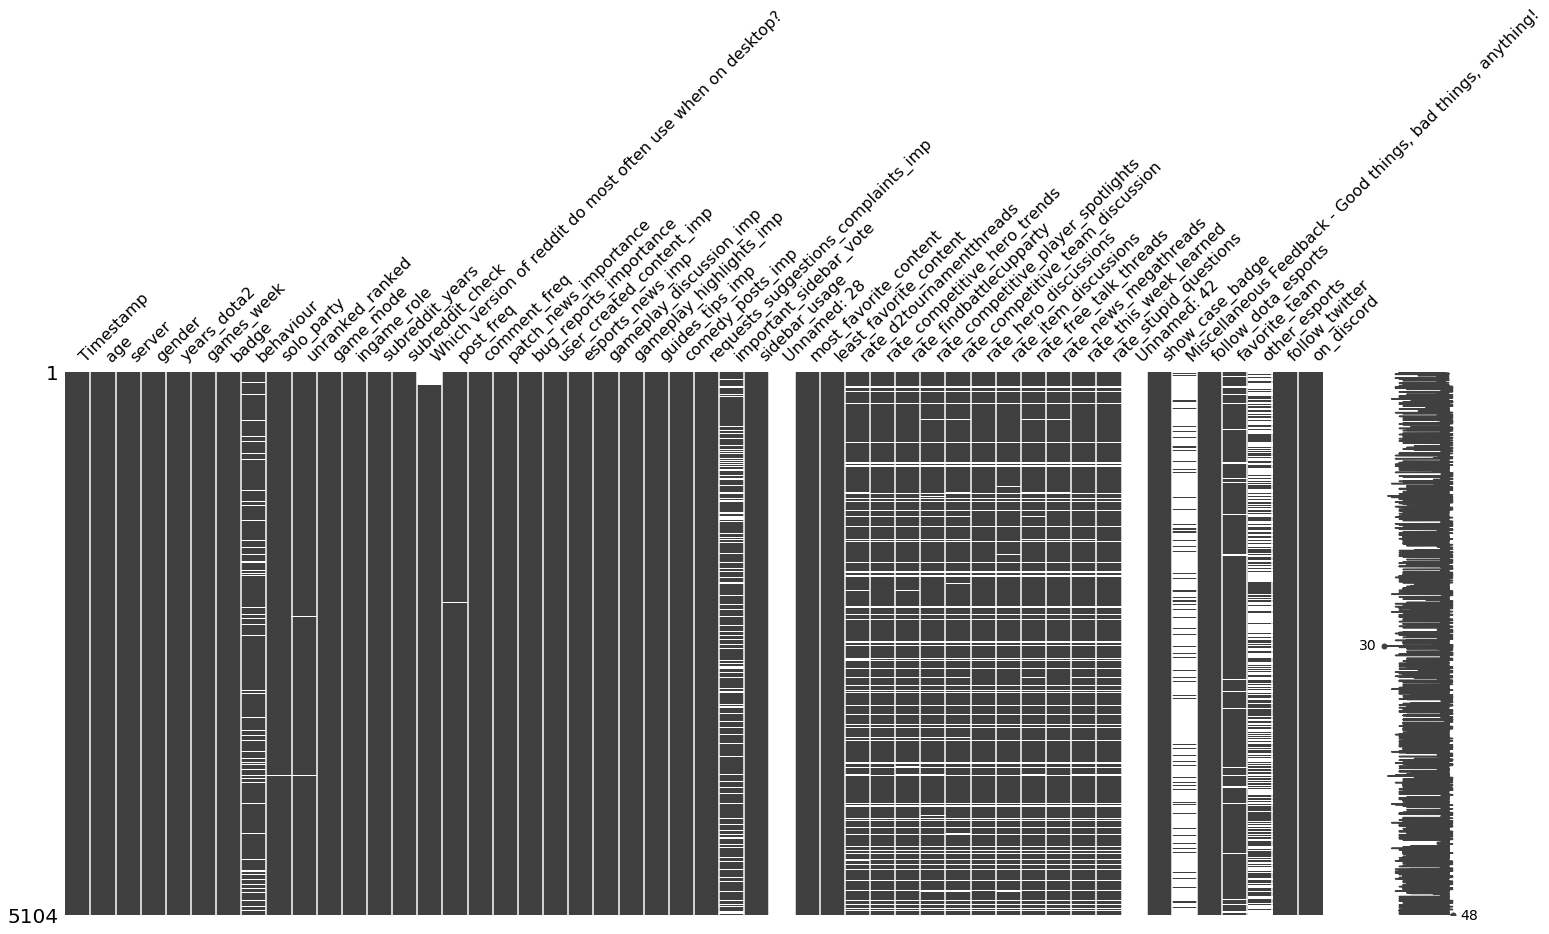

In [3341]:
# Look at all missing data
msno.matrix(dota);

In [3342]:
dota = dota.drop(columns=['Which version of reddit do most often use when on desktop?', 'important_sidebar_vote', 'Unnamed: 28', 'Unnamed: 42', 
                          'Miscellaneous Feedback - Good things, bad things, anything!']) # drop empty columns/irrelevant rows

dota.other_esports.fillna('None', inplace=True) # replacing missing values with "None"

In [3343]:
# drop all rows with missing data in selected column with most missing (700)
dota = dota[pd.notnull(dota['rate_competitive_player_spotlights'])] 

In [3344]:
# impute remaining missing values
dota.fillna(dota.mean(), inplace=True)

In [3345]:
# drop 2 rows missing "least favorite content"
dota = dota.drop([1,2])

In [3346]:
# favorite team, if nan, replace with "None" otherwise group all answers under 100 responses
top_teams = dota.favorite_team.value_counts()
top_teams = top_teams.reset_index(drop=False)
top_teams.columns = ['Team', 'Count']
other_cat = top_teams[top_teams['Count'] < 100] # Reduce list 'other' for all responses with fewer than 100 counts
other_cat = list(other_cat.Team)

dota.loc[dota['favorite_team'].isin(other_cat), "favorite_team"] = 'Other' # change all entries to Other

dota.favorite_team = dota.favorite_team.fillna(value='None') # replace nan with None

In [3347]:
# Combining responses for show_case_badge
top_responses = dota.show_case_badge.value_counts()
top_responses = top_responses.reset_index(drop=False)
top_responses.columns = ['Response', 'Count']
other_cat = top_responses[top_responses['Count'] < 200]
other_cat = list(other_cat.Response)

In [3348]:
# Replace any non-standard response
dota.loc[dota['show_case_badge'].isin(other_cat), "show_case_badge"] = 'Other'

In [3349]:
# Combine responses on other esports
top_responses = dota.other_esports.value_counts()
top_responses = top_responses.reset_index(drop=False)
top_responses.columns = ['Other', 'Count']
other_cat = top_responses[top_responses['Count'] < 25]
other_cat = list(other_cat.Other)

In [3350]:
dota.loc[dota['other_esports'].isin(other_cat), "other_esports"] = 'Other'

# Group by region average values

In [3351]:
by_region = round(dota.groupby(by='server').mean(),2)
by_region.sort_values(by='age', ascending=False)

,age,years_dota2,games_week,behaviour,solo_party,unranked_ranked,subreddit_years,post_freq,comment_freq,patch_news_importance,...,rate_competitive_hero_trends,rate_findbattlecupparty,rate_competitive_player_spotlights,rate_competitive_team_discussion,rate_hero_discussions,rate_item_discussions,rate_free_talk_threads,rate_news_megathreads,rate_this_week_learned,rate_stupid_questions
server,,,,,,,,,,,,,,,,,,,,,
Japan,26.69,6.03,4.33,0.90,2.65,3.32,2.44,0.41,0.69,3.69,...,2.45,1.69,2.21,2.41,2.69,2.55,1.83,2.62,2.34,2.52
Chile,26.10,6.38,11.71,0.85,2.14,3.33,3.07,0.81,1.43,3.62,...,2.14,1.62,2.19,1.90,2.38,2.52,1.86,2.14,2.33,2.57
South Africa,25.59,6.14,10.53,0.98,3.14,1.93,2.48,0.52,0.86,3.82,...,2.55,1.52,2.48,2.42,2.80,2.68,1.82,2.72,2.41,2.65
US West,25.18,5.80,8.63,0.98,2.77,3.26,3.17,0.43,0.93,3.84,...,2.67,1.76,2.23,2.33,2.57,2.49,1.87,2.74,2.12,2.36
South America,25.16,6.56,8.02,0.96,2.79,3.39,2.94,0.43,0.95,3.85,...,2.65,1.69,2.35,2.35,2.57,2.54,1.81,2.70,2.20,2.35
China,24.89,5.48,12.44,1.00,2.22,3.38,2.56,0.44,1.33,3.11,...,2.22,1.67,2.00,2.11,2.40,2.22,2.00,2.56,1.78,2.00
Europe West,24.88,5.89,9.48,0.97,2.95,3.50,3.05,0.46,0.92,3.77,...,2.54,1.73,2.21,2.33,2.53,2.45,1.88,2.73,2.09,2.36
Australia,24.74,5.69,9.62,0.97,2.99,2.96,3.09,0.50,0.87,3.77,...,2.60,1.68,2.23,2.38,2.66,2.54,1.78,2.65,2.01,2.38
US East,24.71,5.59,8.36,0.98,2.89,3.30,3.13,0.42,0.88,3.81,...,2.68,1.84,2.24,2.44,2.70,2.64,1.93,2.86,2.22,2.49


## Scaling

In [3352]:
original_scaled = dota[['age', 'years_dota2', 'games_week']]

In [3353]:
# Fix the scaling for age, years_dota2, and games_week by standardizing (Xi - u/ std)
to_scale = ['age', 'years_dota2', 'games_week']
dota[to_scale] = dota[to_scale].apply(lambda x: (x-x.mean())/x.std())

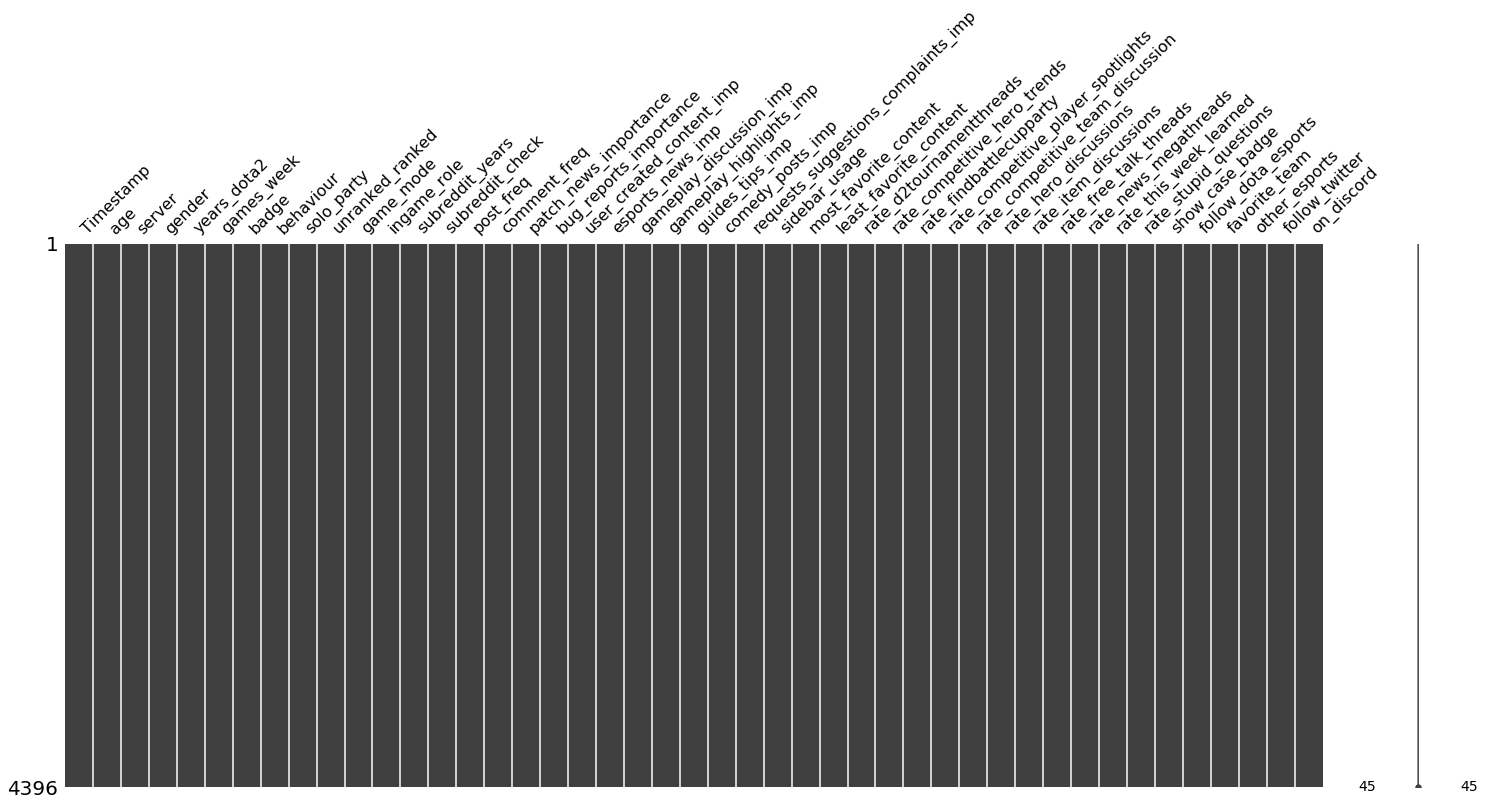

In [3354]:
msno.matrix(dota);

In [3355]:
# drop Timestamp for pca
dota.drop(labels='Timestamp', axis=1, inplace=True)

## Dummy Encoding

In [3356]:
# Use a dummy encoder for the remaining categorical columns that can't be easily converted to numeric values

clean = pd.get_dummies(dota, columns=['server', 'gender' ,'badge' ,'game_mode' ,'ingame_role' ,'subreddit_check', 'sidebar_usage', 
                              'most_favorite_content', 'least_favorite_content', 'show_case_badge', 'follow_dota_esports', 
                              'favorite_team', 'other_esports', 'follow_twitter' ,'on_discord'])

## Correlation check and PCA

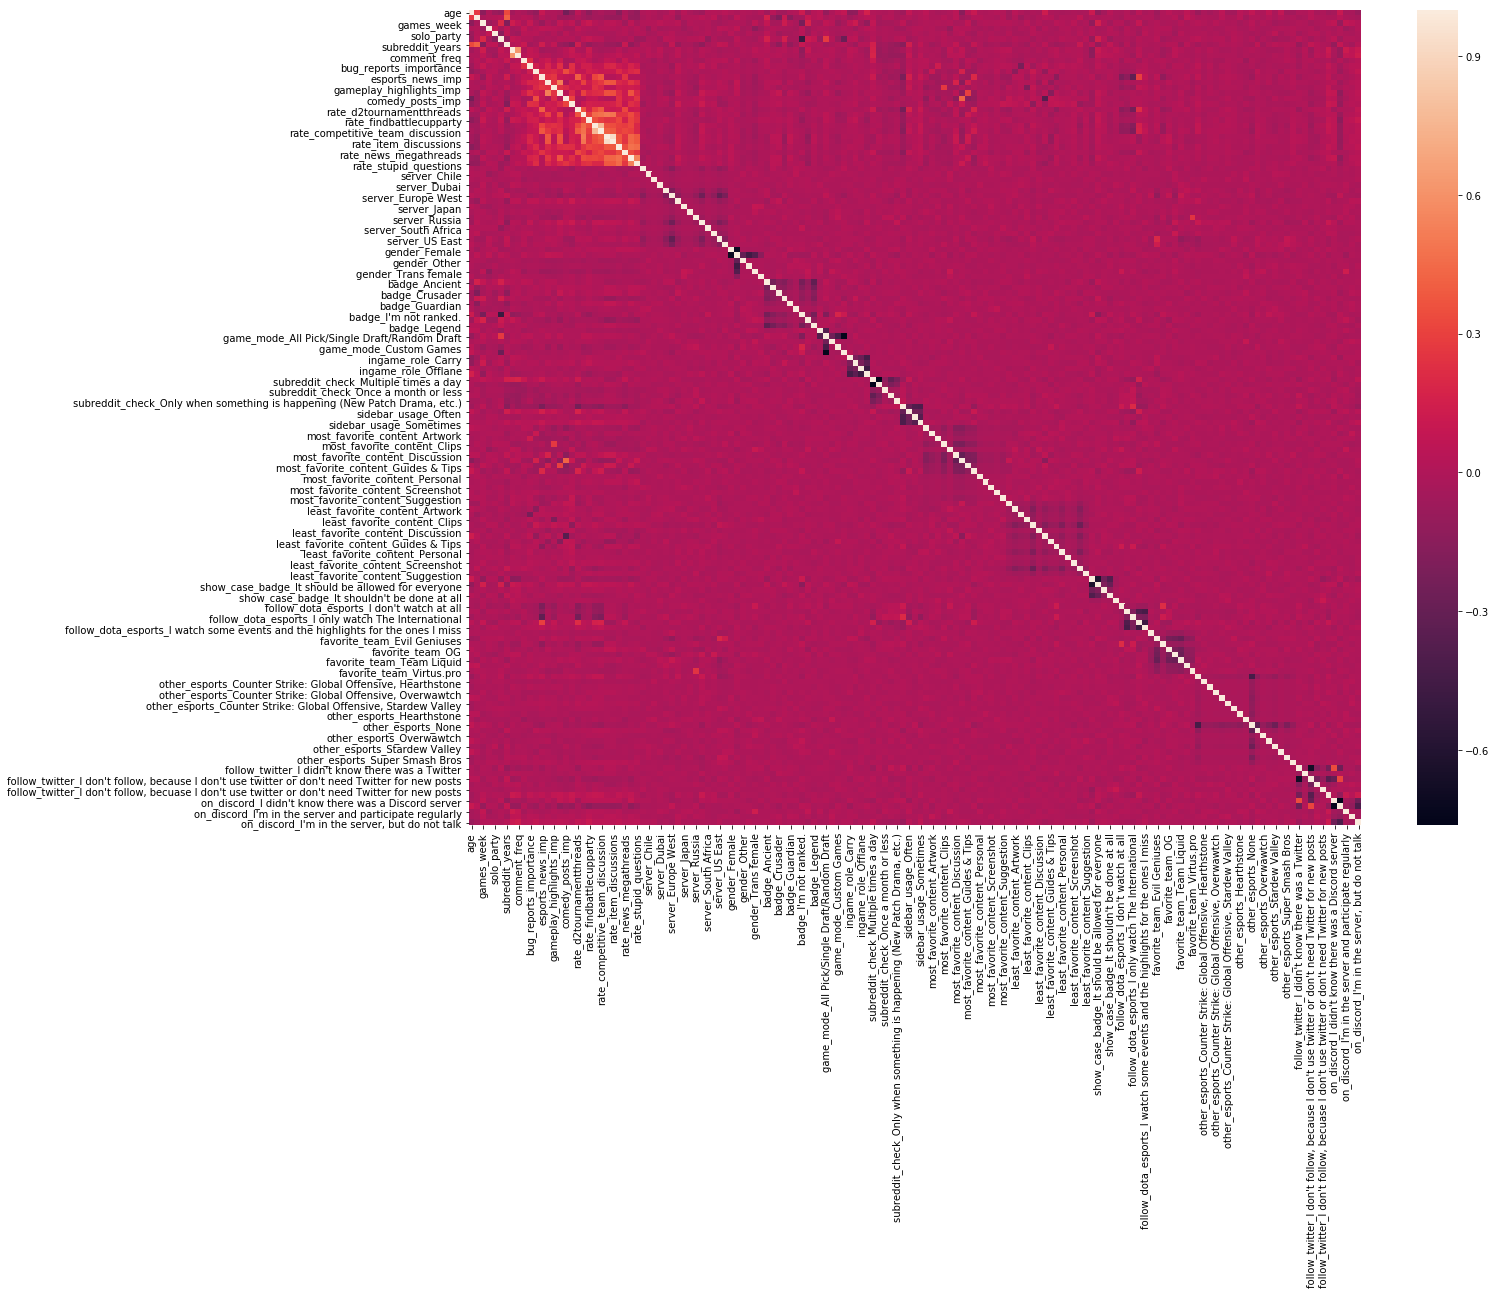

In [3250]:
# make a correlation plot
plt.figure(figsize = (20, 15))
corr = clean.corr()
sns.heatmap(corr);

In [3251]:
# Set components to check variance, n_components = sqrt(152), int(round(np.sqrt(152),0))
PCA = PCA(n_components=25, random_state=43)
PCA.fit(clean)

PCA(copy=True, iterated_power='auto', n_components=25, random_state=43,
  svd_solver='auto', tol=0.0, whiten=False)

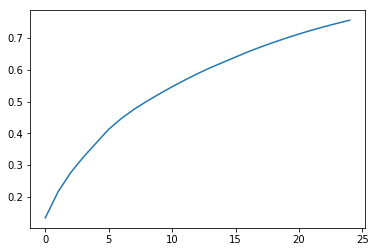

In [3252]:
# plot variance ratios to check dimensionality
plt.figure()
plt.plot(np.cumsum(PCA.explained_variance_ratio_))
plt.show()

In [3253]:
sum(PCA.explained_variance_ratio_)

0.7564108604561584

In [3254]:
PCA.explained_variance_ratio_

array([0.1329173 , 0.08193511, 0.06093519, 0.04882498, 0.04418015,
       0.04363411, 0.0341733 , 0.02902967, 0.02520411, 0.02342994,
       0.02233409, 0.02119817, 0.02000221, 0.01859093, 0.01698596,
       0.01688574, 0.01673483, 0.01539584, 0.01427357, 0.01348509,
       0.01287578, 0.01189297, 0.01122937, 0.01038042, 0.00988202])

## Cluster Analysis

In [3255]:
# run KMeans with set clusters
clusterer = KMeans(n_clusters=5, random_state=42)
labels = clusterer.fit_predict(clean)

In [3256]:
# add labels to dataset
clean['Cluster'] = labels + 1 #non-0 clusters

In [3257]:
# Move last column to front (Cluster)
cols = list(clean.columns)
cols = [cols[-1]] + cols[:-1]
clean = clean[cols]

In [3258]:
# create dict for renaming columns to clean up after dummy variable (removing ./etc)
cols = clean.columns
original_cols = [i for i in cols]

rename = ['Cluster',
'age',
'years_dota2',
'games_week',
'behaviour',
'solo_party',
'unranked_ranked',
'subreddit_years',
'post_freq',
'comment_freq',
'patch_news_importance',
'bug_reports_importance',
'user_created_content_imp',
'esports_news_imp',
'gameplay_discussion_imp',
'gameplay_highlights_imp',
'guides_tips_imp',
'comedy_posts_imp',
'requests_suggestions_complaints_imp',
'rate_d2tournamentthreads',
'rate_competitive_hero_trends',
'rate_findbattlecupparty',
'rate_competitive_player_spotlights',
'rate_competitive_team_discussion',
'rate_hero_discussions',
'rate_item_discussions',
'rate_free_talk_threads',
'rate_news_megathreads',
'rate_this_week_learned',
'rate_stupid_questions',
'server_Australia',
'server_Chile',
'server_China',
'server_Dubai',
'server_Europe_East',
'server_Europe_West',
'server_India',
'server_Japan',
'server_Peru',
'server_Russia',
'server_SE_Asia',
'server_South_Africa',
'server_South_America',
'server_US_East',
'server_US_West',
'gender_Female',
'gender_Male',
'gender_Other',
'gender_Prefer_not_to_say',
'gender_Trans_female',
'gender_Trans-male',
'badge_Ancient',
'badge_Archon',
'badge_Crusader',
'badge_Divine',
'badge_Guardian',
'badge_Herald',
"badge_Im_not_ranked",
'badge_Immortal',
'badge_Legend',
'game_mode_Ability_Draft',
'game_mode_All_Pick_Single_Draft_Random_Draft',
'game_mode_Captains_Mode_Captains_Draft',
'game_mode_Custom_Games',
'game_mode_Turbo',
'ingame_role_Carry',
'ingame_role_Mid',
'ingame_role_Offlane',
'ingame_role_Support_(4_5)',
'subreddit_check_Multiple_times_a_day',
'subreddit_check_Once_a_day',
'subreddit_check_Once_a_month_or_less',
'subreddit_check_Once_a_week',
'subreddit_check_Only_when_something_is_happening_(New_Patch_Drama,_etc)',
'sidebar_usage_Never',
'sidebar_usage_Often',
'sidebar_usage_Seldom',
'sidebar_usage_Sometimes',
'most_favorite_content_Article',
'most_favorite_content_Artwork',
'most_favorite_content_Bug',
'most_favorite_content_Clips',
'most_favorite_content_Complaint',
'most_favorite_content_Discussion',
'most_favorite_content_Fluff',
'most_favorite_content_Guides_&_Tips',
'most_favorite_content_Match',
'most_favorite_content_Personal',
'most_favorite_content_Question',
'most_favorite_content_Screenshot',
'most_favorite_content_Shoutout',
'most_favorite_content_Suggestion',
'least_favorite_content_Article',
'least_favorite_content_Artwork',
'least_favorite_content_Bug',
'least_favorite_content_Clips',
'least_favorite_content_Complaint',
'least_favorite_content_Discussion',
'least_favorite_content_Fluff',
'least_favorite_content_Guides_&_Tips',
'least_favorite_content_Match',
'least_favorite_content_Personal',
'least_favorite_content_Question',
'least_favorite_content_Screenshot',
'least_favorite_content_Shoutout',
'least_favorite_content_Suggestion',
"show_case_badge_I_dont_care",
'show_case_badge_It_should_be_allowed_for_everyone',
'show_case_badge_It_should_only_be_allowed_for_very_high_ranked_players',
"show_case_badge_It_shouldnt_be_done_at_all",
'show_case_badge_Other',
"follow_dota_esports_I_dont_watch_at_all",
'follow_dota_esports_I_follow_only_the_major_tournaments_(more_than_just_The_International)',
'follow_dota_esports_I_only_watch_The_International',
'follow_dota_esports_I_watch_nearly_every_event',
'follow_dota_esports_I_watch_some_events_and_the_highlights_for_the_ones_I_miss',
'favorite_team_Alliance',
'favorite_team_Evil_Geniuses',
'favorite_team_None'
'favorite_team_OG',
'favorite_team_Other',
'favorite_team_Team_Liquid',
'favorite_team_Team_Secret',
'favorite_team_Virtus_pro',
'other_esports_Counter_Strike_Global_Offensive',
'other_esports_Counter_Strike_Global_Offensive_Hearthstone',
'other_esports_Counter_Strike_Global_Offensive_League_of_Legends',
'other_esports_Counter_Strike_Global_Offensive_Overwawtch',
'other_esports_Counter_Strike_Global_Offensive_Starcraft',
'other_esports_Counter_Strike_Global_Offensive_Stardew_Valley',
'other_esports_Counter_Strike_Global_Offensive_Super_Smash_Bros',
'other_esports_Hearthstone',
'other_esports_League_of_Legends',
'other_esports_None',
'other_esports_Other',
'other_esports_Overwawtch',
'other_esports_Starcraft',
'other_esports_Stardew_Valley',
'other_esports_Street_Fighter',
'other_esports_Super_Smash_Bros',
'other_esports_Super_Smash_Bros_Stardew_Valley',
"follow_twitter_I_didnt_know_there_was_a_Twitter",
"follow_twitter_I_dont_follow_because_it_doesnt_tweet_enough",
"follow_twitter_I_dont_follow_because_I_dont_use_twitter_or_dont_need_Twitter_for_new_posts",
"follow_twitter_I_dont_follow_because_its_too_spammy",
"follow_twitter_I_dont_follow_becuase_I_dont_use_twitter_or_dont_need_Twitter_for_new_posts",
'follow_twitter_I_follow_and_use_to_see_the_new_posts_trending_on_the_subreddit',
"on_discord_I_didnt_know_there_was_a_Discord_server",
'on_discord_I_have_no_interest_in_joining_the_Discord_server',
"on_discord_Im_in_the_server_and_participate_regularly",
"on_discord_Im_in_the_server_and_participate_sometimes",
"on_discord_Im_in_the_server_but_do_not_talk"]

In [3259]:
renaming_dict = dict(zip(original_cols, rename))

In [3260]:
df = clean
df.columns = df.columns.map(renaming_dict)

In [3261]:
### skip below to save time if production of looped graphs is unnecessary ###
### Loops over # of clusters and creates graphs, and then hstack and vstack to combine images ###
### converted to raw and only run if needed ###

## Post analysis of the graphs and looks like 3 is a good choice for labels

In [3262]:
# Assign cluster labels using n_clusters=3
clusterer = KMeans(n_clusters=3, random_state=42)
cluster_labels = clusterer.fit_predict(clean)
clean.Cluster = cluster_labels

In [3263]:
# revert scaled values for graphs and cluster analysis
#clean['age'] = original_scaled['age']
#clean['years_dota2'] = original_scaled['years_dota2']
#clean['games_week'] = original_scaled['games_week']

In [3264]:
y = clean.Cluster
X = clean

In [3265]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [3266]:
# Assign cluster labels 1-3 for prediction 

cluster_labels = clusterer.predict(X_train)
X_train['Predictions'] = cluster_labels

C:\Users\jason\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [3267]:
df_confusion_train = pd.crosstab(X_train.Cluster, X_train.Predictions)
df_confusion_train

Predictions,0,1,2
Cluster,,,
0,745,0,0
1,274,502,417
2,17,0,1122


In [3268]:
cluster_labels = clusterer.predict(X_test)
X_test['Predictions'] = cluster_labels

df_confusion_test = pd.crosstab(X_test.Cluster, X_test.Predictions)
df_confusion_test

C:\Users\jason\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Predictions,0,1,2
Cluster,,,
0,312,0,0
1,126,244,175
2,13,0,449


In [3160]:
df_confusion_train = pd.crosstab(X_train.Cluster, X_train.Predictions)
df_confusion_train

Predictions,0,1,2
Cluster,,,
0,745,0,0
1,274,502,417
2,17,0,1122


In [3161]:
df_confusion_test = pd.crosstab(X_test.Cluster, X_test.Predictions)
df_confusion_test

Predictions,0,1,2
Cluster,,,
0,312,0,0
1,126,244,175
2,13,0,449
